In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

# from collections import deque
# from scipy.stats import linregress
# from scipy.optimize import curve_fit
# import math
# from scipy import stats

import logging
import traceback
import json
import time

In [2]:
#!/usr/bin/env python3

import os
import sys
import time
import shutil
import logging
import argparse
import numpy as np
import json
import traceback
from scipy import stats

import custom_script
from custom_script import EXP_NAME
from custom_script import EVOLVER_PORT, OPERATION_MODE
from custom_script import STIR_INITIAL, TEMP_INITIAL
from custom_script import VOLUME
import seaborn as sns
import pandas as pd

SAVE_PATH = os.getcwd()
EXP_DIR = os.path.join(SAVE_PATH, EXP_NAME)
PUMP_CAL_PATH = os.path.join(SAVE_PATH, 'pump_cal.json')

SIGMOID = 'sigmoid'
LINEAR = 'linear'
THREE_DIMENSION = '3d'

logger = logging.getLogger('eVOLVER')


Running simulation...
Experiment initialized. Time spent initializing: 0.02 seconds
Simulation complete. Time spent iterating: 2.36 seconds


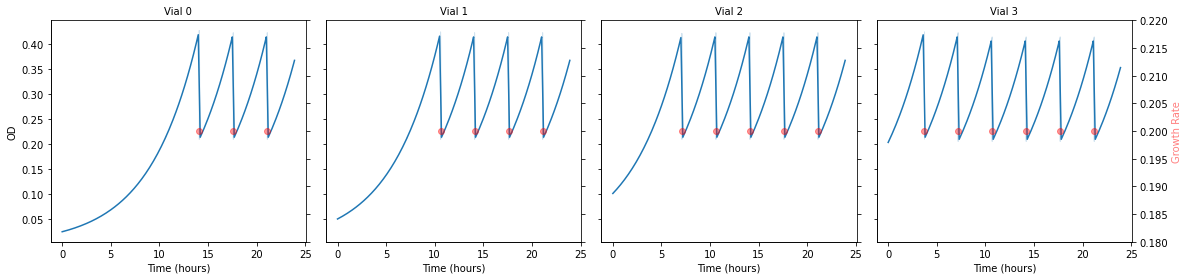

In [5]:
class EvolverSimulation:
    def __init__(self, experiment_params):
        self.exp_dir = SAVE_PATH
        self.custom_function = experiment_params['custom_function']
        self.vials = experiment_params['vials'] # vial numbers
        self.log_name = experiment_params['log_name']

        # Time variables
        self.duration = experiment_params['duration'] # hours; duration of the experiment
        self.start_time = 0 # hours
        self.elapsed_time = 0 # hours
        self.minute = 1/60 # hours
        self.time_interval = experiment_params['time_interval'] # hours; time of each iteration
        
        # Biological variables
        self.ODs = experiment_params['initial_ODs'] # optical density
        self.max_OD = experiment_params['max_OD']
        self.growth_rates = experiment_params['initial_grs'] # growth rate

        # Fluidics variables
        self.min_fast = 0.5 # ml; minimum bolus to pump using fast pumps
        self.min_slow = 0.1 # ml; minimum bolus to pump using slow pumps
        self.volume = experiment_params['vial_volume'] # mL 

        # eVOLVER adaptation variables - for making this script work with actual eVOLVER code
        self.experiment_params = None
        self.transformed_ODs = {'transformed': {'od':self.ODs}}
        self.filename_to_foldername = {'OD':'OD', 'pump_log':'pump_log', 'ODset':'ODset', 'gr':'growthrate', 'chemo_config':'chemo_config'}
        self.foldername_to_filename = {'OD':'OD', 'pump_log':'pump_log', 'ODset':'ODset', 'growthrate':'gr', 'chemo_config':'chemo_config'}
        self.name_to_columnnames = {'OD' : ['Time', 'OD'], 'pump_log' : ['Time', 'Pump'], 'ODset' : ['Time', 'ODset'], 'growthrate' : ['Time', 'Growth Rate']}

        # Simulation variables
        self.working_time = 0

    def run_simulation(self):
        """Run the simulation."""
        start_time = time.time()
        print('Running simulation...')

        self.initialize_exp(self.vials, self.log_name, 0, 0)
        print(f'Experiment initialized. Initialization time: {time.time()-start_time:.2f} seconds')
        
        while self.elapsed_time < self.duration:
            self.simulate_step()
        print(f'Simulation complete. Iteration time: {self.working_time:.2f} seconds')

    def simulate_step(self):
        """Simulate one time step for all vials."""
        start_time = time.time()
        self.grow() # Grow the cells one step in all vials.
        self.custom_functions(self.transformed_ODs, self.vials, self.elapsed_time)
        self.elapsed_time += self.time_interval
        self.working_time += time.time() - start_time
    
    def grow(self):
        """Grow the cells one step in all vials."""
        for vial in self.vials:
            if self.ODs[vial] >= self.max_OD:
                self.growth_rates[vial] = 0
            else:
                self.ODs[vial] = self.exponential_growth(self.time_interval, self.ODs[vial], self.growth_rates[vial])
        self.save_data(self.ODs, self.elapsed_time, self.vials, 'OD')

    def exponential_growth(self, x, a, b):
        return a * np.exp(b * x)
    
    def fluid_command(self, MESSAGE):
        logger.debug('fluid command: %s' % MESSAGE)
        self.simulate_fluidics(MESSAGE)
    
    def simulate_fluidics(self, MESSAGE):
        """Makes dilutions in vials based off of flow rates and time to pump."""
        flow_rate = self.get_flow_rate()
        influx = MESSAGE[:16]
        logger.info(f'Elapsed Time: {self.elapsed_time}')
        for vial in self.vials:
            if influx[vial] == '--':
                continue
            bolus_in_mL = flow_rate[vial] * float(influx[vial])
            OD_decrease = np.exp(-bolus_in_mL/VOLUME)
            self.ODs[vial] = self.ODs[vial] * OD_decrease
            logger.info(f'Vial {vial}: Pumped {bolus_in_mL:.3f} mL, OD decreased by {OD_decrease:.3f}X to {self.ODs[vial]:.3f} from {round(self.ODs[vial] / OD_decrease,3)}')
        self.save_data(self.ODs, self.elapsed_time, self.vials, 'OD')

    def plot_data(self, vials, left_data_type, right_data_type=None):
        """
        Plot the data for the given vials and parameter using seaborn.
        Parameters:
            vials: list of vials to plot
            left_data_type: data type to plot on the left y-axis
            right_data_type: data type to plot on the right y-axis
        """
        left_data = self.load_data(left_data_type)
        
        g = sns.FacetGrid(left_data, col="Vial", col_wrap=4, height=4, sharey=True)
        g.map(sns.lineplot, "Time", left_data_type)
        g.set_axis_labels("Time (hours)", left_data_type)
        g.set_titles("Vial {col_name}")

        if right_data_type:
            right_data = self.load_data(right_data_type, header=2)
            col_name = self.name_to_columnnames[right_data_type][1]
            min_right_data = right_data[col_name].min() * 0.9
            max_right_data = right_data[col_name].max() * 1.1

            for ax, vial in zip(g.axes.flat, g.col_names):
                # Only show ticks on the left and bottom for outer plots
                if not ax.get_subplotspec().is_first_col():
                    ax.tick_params(labelleft=False)
                if not ax.get_subplotspec().is_last_row():
                    ax.tick_params(labelbottom=False)

                df2 = right_data[right_data['Vial'] == vial]
                ax2 = ax.twinx()
                ax2.set_ylabel(col_name, color='red', alpha=0.5)
                ax2.scatter(df2['Time'], df2[col_name], color='red', alpha=0.4)
                ax2.set_ylim(min_right_data, max_right_data)
                if not ax2.get_subplotspec().is_last_col(): # remove ticks on right for inner plots
                    ax2.tick_params(labelleft=False)
                    ax2.tick_params(labelright=False)
                    ax2.set_ylabel('')

        plt.show()

    def load_data(self, data_type, header=1):
        '''Load data from the experiment folder for the given data type.'''
        data = []
        colnames = self.name_to_columnnames[data_type]
    
        for vial in self.vials:
            file_name =  "vial{0}_{1}.txt".format(vial, self.foldername_to_filename[data_type])
            file_path = os.path.join(EXP_DIR, data_type, file_name)
            vial_data = np.genfromtxt(file_path, delimiter=',', skip_header=header)
            vial_df = pd.DataFrame(vial_data, columns=colnames)
            vial_df['Vial'] = vial
            data.append(vial_df)
    
        return pd.concat(data)

    def initialize_exp(self, vials, log_name, quiet, verbose):

        logger.debug('creating data directories')
        # First, check if directory exists, if not, create it
        if not os.path.exists(EXP_DIR):
            for directory in ['OD', 'pump_log', 'ODset', 'growthrate', 'chemo_config']:
                    os.makedirs(os.path.join(EXP_DIR, directory))

        # Blank old log file if it exists
        if os.path.exists(log_name):
            open(log_name, 'w').close()
        setup_logging(log_name, quiet, verbose)
        for x in vials:
            exp_str = "Experiment: {0} vial {1}, {2}".format(EXP_NAME,
                                                                x,
                                                        time.strftime("%c"))
            # make OD file
            self._create_file(x, 'OD', defaults=[exp_str])
            # make pump log file
            self._create_file(x, 'pump_log',
                                defaults=[exp_str,
                                        "0,0"])
            # make ODset file
            self._create_file(x, 'ODset',
                                defaults=[exp_str,
                                        "0,0"])
            # make growth rate file
            self._create_file(x, 'gr',
                                defaults=[exp_str,
                                        "0,0"],
                                directory='growthrate')
            # make chemostat file
            self._create_file(x, 'chemo_config',
                                defaults=["0,0,0",
                                        "0,0,0"],
                                directory='chemo_config')

    def _create_file(self, vial, param, directory=None, defaults=None):
        if defaults is None:
            defaults = []
        if directory is None:
            directory = param
        file_name =  "vial{0}_{1}.txt".format(vial, param)
        file_path = os.path.join(EXP_DIR, directory, file_name)
        text_file = open(file_path, "w")
        for default in defaults:
            text_file.write(default + '\n')
        text_file.close()

    def save_data(self, data, elapsed_time, vials, parameter):
        if len(data) == 0:
            return
        for x in vials:
            file_name =  "vial{0}_{1}.txt".format(x, parameter)
            file_path = os.path.join(EXP_DIR, parameter, file_name)
            text_file = open(file_path, "a+")
            text_file.write("{0},{1}\n".format(elapsed_time, data[x]))
            text_file.close()

    def update_chemo(self, data, vials, bolus_in_s, period_config, immediate = False):
        current_pump = data['config']['pump']['value']

        MESSAGE = {'fields_expected_incoming': 49,
                   'fields_expected_outgoing': 49,
                   'recurring': True,
                   'immediate': immediate,
                   'value': ['--'] * 48,
                   'param': 'pump'}

        for x in vials:
            # stop pumps if period is zero
            if period_config[x] == 0:
                # influx
                MESSAGE['value'][x] = '0|0'
                # efflux
                MESSAGE['value'][x + 16] = '0|0'
            else:
                # influx
                MESSAGE['value'][x] = '%.2f|%d' % (bolus_in_s[x], period_config[x])
                # efflux
                MESSAGE['value'][x + 16] = '%.2f|%d' % (bolus_in_s[x] * 2,
                                                        period_config[x])

        if MESSAGE['value'] != current_pump:
            logger.info('updating chemostat: %s' % MESSAGE)
            self.emit('command', MESSAGE, namespace = '/dpu-evolver')

    def stop_all_pumps(self, ):
        data = {'param': 'pump',
                'value': ['0'] * 48,
                'recurring': False,
                'immediate': True}
        logger.info('stopping all pumps')

    def get_flow_rate(self):
        pump_cal = None
        with open(PUMP_CAL_PATH) as f:
            pump_cal = json.load(f)
        return pump_cal['coefficients']

    def calc_growth_rate(self, vial, gr_start, elapsed_time):
        ODfile_name =  "vial{0}_OD.txt".format(vial)
        # Grab Data and make setpoint
        OD_path = os.path.join(EXP_DIR, 'OD', ODfile_name)
        OD_data = np.genfromtxt(OD_path, delimiter=',')
        raw_time = OD_data[:, 0]
        raw_OD = OD_data[:, 1]
        raw_time = raw_time[np.isfinite(raw_OD)]
        raw_OD = raw_OD[np.isfinite(raw_OD)]

        # Trim points prior to gr_start
        trim_time = raw_time[np.nonzero(np.where(raw_time > gr_start, 1, 0))]
        trim_OD = raw_OD[np.nonzero(np.where(raw_time > gr_start, 1, 0))]

        # Take natural log, calculate slope
        log_OD = np.log(trim_OD)
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            trim_time[np.isfinite(log_OD)],
            log_OD[np.isfinite(log_OD)])
        logger.debug('growth rate for vial %s: %.2f' % (vial, slope))

        # Save slope to file
        file_name =  "vial{0}_gr.txt".format(vial)
        gr_path = os.path.join(EXP_DIR, 'growthrate', file_name)
        text_file = open(gr_path, "a+")
        text_file.write("{0},{1}\n".format(elapsed_time, slope))
        text_file.close()

    def tail_to_np(self, path, window=10, BUFFER_SIZE=512):
        """
        Reads file from the end and returns a numpy array with the data of the last 'window' lines.
        Alternative to np.genfromtxt(path) by loading only the needed lines instead of the whole file.
        """
        f = open(path, 'rb')
        if window == 0:
            return []

        f.seek(0, os.SEEK_END)
        remaining_bytes = f.tell()
        size = window + 1  # Read one more line to avoid broken lines
        block = -1
        data = []

        while size > 0 and remaining_bytes > 0:
            if remaining_bytes - BUFFER_SIZE > 0:
                # Seek back one whole BUFFER_SIZE
                f.seek(block * BUFFER_SIZE, os.SEEK_END)
                # read BUFFER
                bunch = f.read(BUFFER_SIZE)
            else:
                # file too small, start from beginning
                f.seek(0, 0)
                # only read what was not read
                bunch = f.read(remaining_bytes)

            bunch = bunch.decode('utf-8')
            data.append(bunch)
            size -= bunch.count('\n')
            remaining_bytes -= BUFFER_SIZE
            block -= 1

        data = ''.join(reversed(data)).splitlines()[-window:]

        if len(data) < window:
            # Not enough data
            return np.asarray([])

        for c, v in enumerate(data):
            data[c] = v.split(',')

        try:
            data = np.asarray(data, dtype=np.float64)
            return data
        except ValueError:
            # It is reading the header
            return np.asarray([])

    def custom_functions(self, data, vials, elapsed_time):
        # load user script from custom_script.py
        if self.custom_function == 'turbidostat':
            custom_script.turbidostat(self, data, vials, elapsed_time)
        # elif self.custom_function == 'chemostat':
        #     custom_script.chemostat(self, data, vials, elapsed_time)
        # elif self.custom_function == 'growthcurve':
        #     custom_script.growth_curve(self, data, vials, elapsed_time)
        else:
            # try to load the user function
            # if failing report to user
            logger.info('user-defined operation mode %s' % self.custom_function)
            try:
                func = getattr(custom_script, self.custom_function)
                func(self, data, vials, elapsed_time)
            except AttributeError:
                logger.error('could not find function %s in custom_script.py' %
                            self.custom_function)
                print('Could not find function %s in custom_script.py '
                    '- Skipping user defined functions'%
                    self.custom_function)

    def stop_exp(self):
        logger.info('stopping experiment')
        print('stopping experiment')

def setup_logging(filename, quiet, verbose):
    if quiet:
        logging.basicConfig(level=logging.CRITICAL + 10)
    else:
        if verbose == 0:
            level = logging.INFO
        elif verbose >= 1:
            level = logging.DEBUG
        logging.basicConfig(format='%(asctime)s - %(name)s - [%(levelname)s] '
                            '- %(message)s',
                            datefmt='%Y-%m-%d %H:%M:%S',
                            filename=filename,
                            level=level)
        
vials = [0,1,2,3]#,4,5,6,7,8,9,10,11,12,13,14,15] # vial numbers to run the experiment on
experiment_params = {
    'vials': vials,
    'custom_function': 'turbidostat',
    'duration': 24, # hours; duration of the experiment
    'initial_ODs' : [0.025,0.05,0.1,0.2],
    'initial_grs' : [0.2]*len(vials),#8+[0.2]*8,
    'lower_thresh': [0.5]*len(vials),
    'upper_thresh': [1]*len(vials),

    'vial_volume': VOLUME, # mL
    'time_interval': 0.1, # hours; time of each iteration | may need to adjust lower if pump_wait in custom_script is too short
    'max_OD' : 4, # as defined by the carrying capacity of media
    'exp_name' : EXP_NAME,
    'log_name': os.path.join(EXP_DIR, 'evolver.log'),
}
log_name = os.path.join(EXP_DIR, 'evolver.log')
simulation = EvolverSimulation(experiment_params)
simulation.run_simulation()
simulation.plot_data(experiment_params['vials'], 'OD', 'growthrate')